## CatBoost: Ordered Statistics + Ordered Boosting

#### < Contents >
- Conventional categorical encoding (one hot, label)
- Target / Mean encoding (Target Statistics)

In [1]:
# 필요한 기본 package 불러오기
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import time
import random
import string

import cufflinks as cf 
cf.go_offline(connected=True)

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import KFold
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')



### Conventional categorical encoding

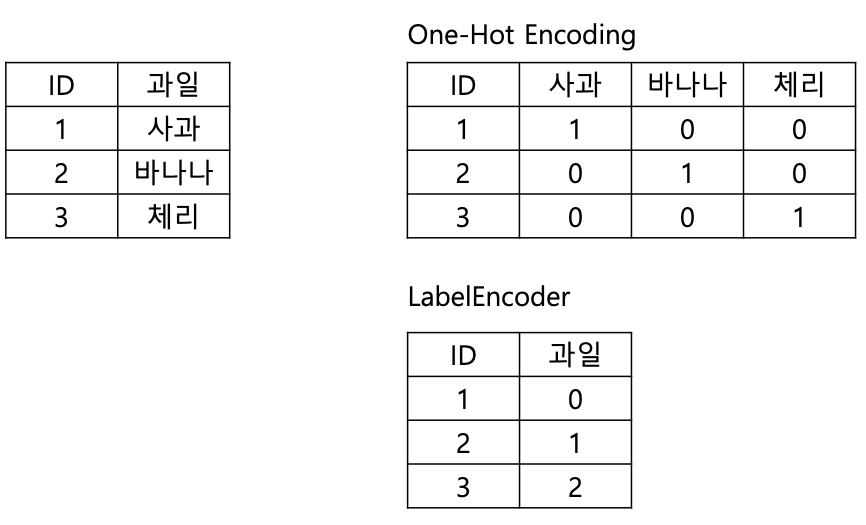

#### (1) One hot encoding

In [2]:
!git clone https://github.com/yun-seon/DX-Training-LGES-0630.git

Cloning into 'DX-Training-LGES-0630'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 86 (delta 6), reused 0 (delta 0), pack-reused 68
Unpacking objects: 100% (86/86), done.


In [3]:
# 데이터 불러오기
df = pd.read_csv('/content/DX-Training-LGES-0630/Data/Data_CatBoost_train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# 성별('Sex') 컬럼은 male과 female로 구성되어 있는 categorical 변수임
# 성별 컬럼은 one hot encoding을 통해 0과 1로 이루어진 2개의 컬럼으로 표현 가능함
df = df.join(pd.get_dummies(df['Sex'], prefix='Sex'))
df[['Sex', 'Sex_female', 'Sex_male']].head()

,Sex,Sex_female,Sex_male
0,male,0,1
1,female,1,0
2,female,1,0
3,female,1,0
4,male,0,1


#### (2) Label encoding

In [5]:
df[['Sex']].head()

,Sex
0,male
1,female
2,female
3,female
4,male


In [6]:
# 성별('Sex') 컬럼은 male과 female로 구성되어 있는 categorical 변수임
# 성별 컬럼은 label encoding을 통해 정수형으로 표현된 하나의 컬럼으로 표현 가능함
df['Sex_label'] = pd.Categorical(df['Sex']).codes
df[['Sex', 'Sex_label']].head()

,Sex,Sex_label
0,male,1
1,female,0
2,female,0
3,female,0
4,male,1


### Target / Mean encoding (Target Statistics)

#### (1) Mean encoding (conventional)

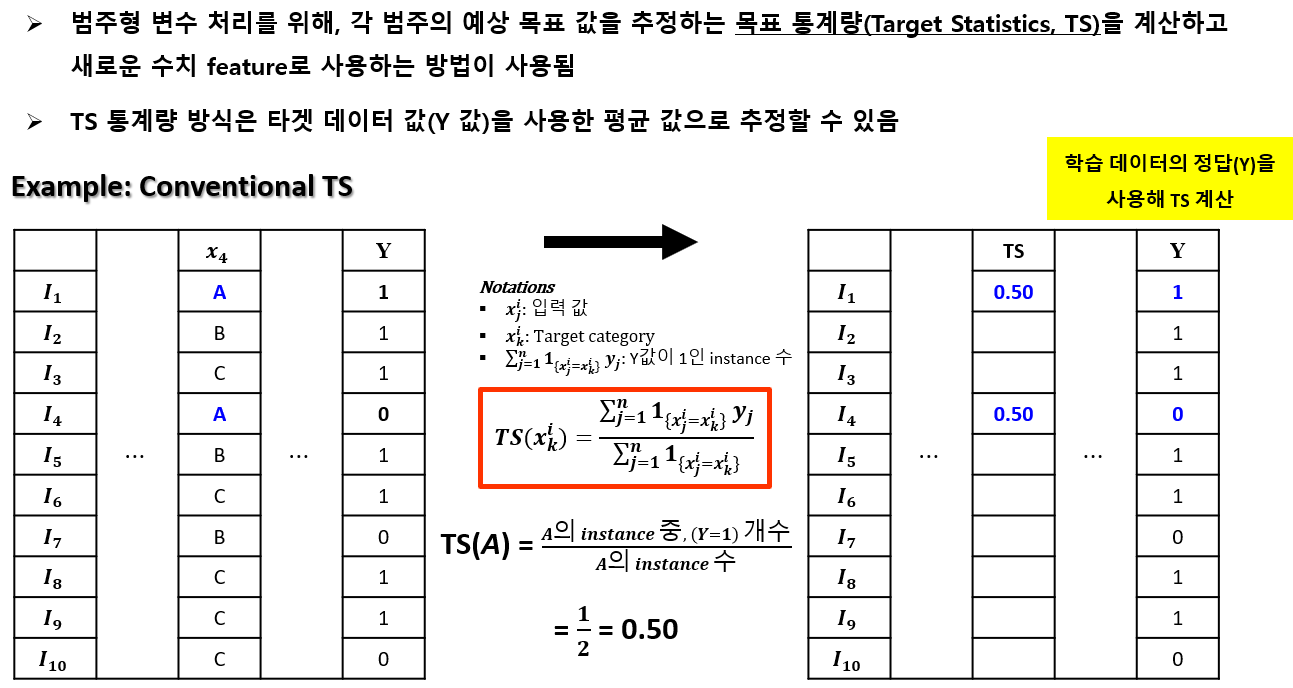

In [7]:
# target 설정
target = 'Survived'

In [8]:
# target 에 대한 sex 내 각 변수의 mean 값을 계산
sex_mean = df.groupby('Sex')[target].mean()
sex_mean

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

In [9]:
# 기존 변수에 encoded 된 값을 매핑
df['Sex_mean'] = df['Sex'].map(sex_mean)
df[['Sex', 'Sex_mean']].head()

,Sex,Sex_mean
0,male,0.188908
1,female,0.742038
2,female,0.742038
3,female,0.742038
4,male,0.188908


#### (2) Smoothing TS

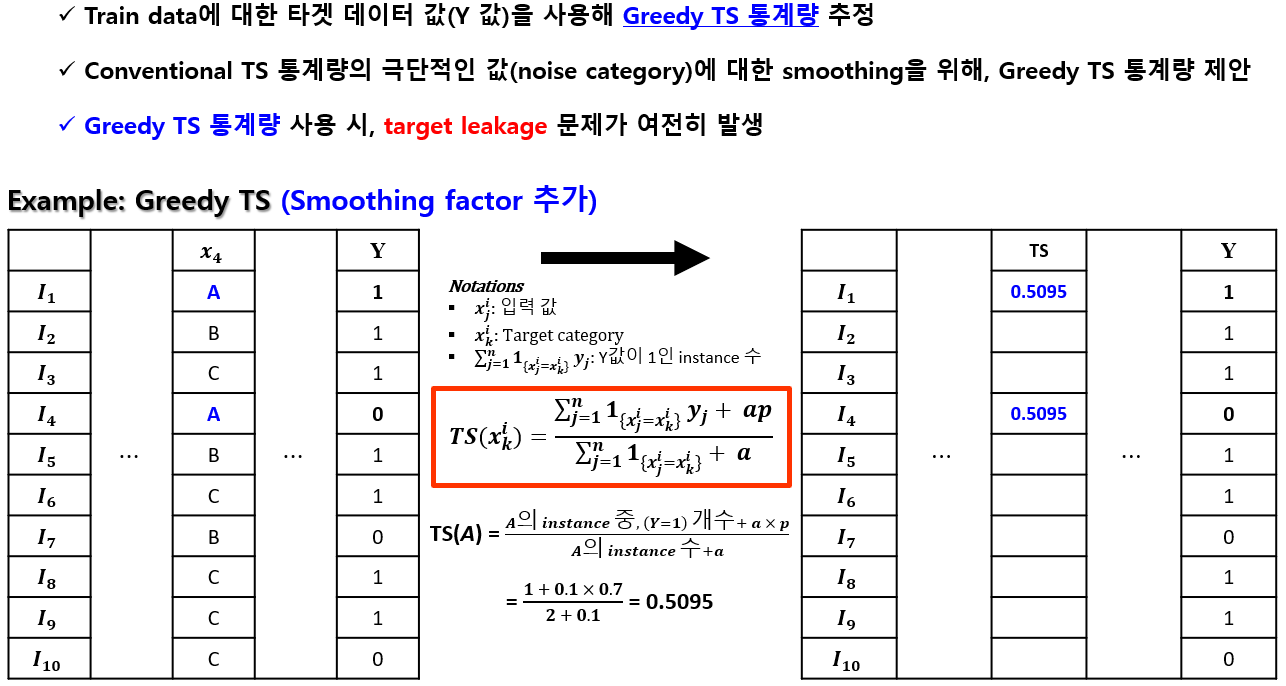

In [10]:
df['Sex_n_rows'] = df['Sex'].map(df.groupby('Sex').size())
global_mean = df[target].mean()
alpha = 0.7 # smoothing을 위해 alpha 값 임의로 설정

def smoothing(n_rows, target_mean):
    return (target_mean*n_rows + global_mean*alpha) / (n_rows + alpha)

df['Sex_mean_smoothing'] = df.apply(lambda x:smoothing(x['Sex_n_rows'], x['Sex_mean']), axis=1)

In [11]:
df[['Sex_mean', 'Sex_mean_smoothing']].head()

,Sex_mean,Sex_mean_smoothing
0,0.188908,0.189144
1,0.742038,0.741241
2,0.742038,0.741241
3,0.742038,0.741241
4,0.188908,0.189144


#### (3) k-fold TS

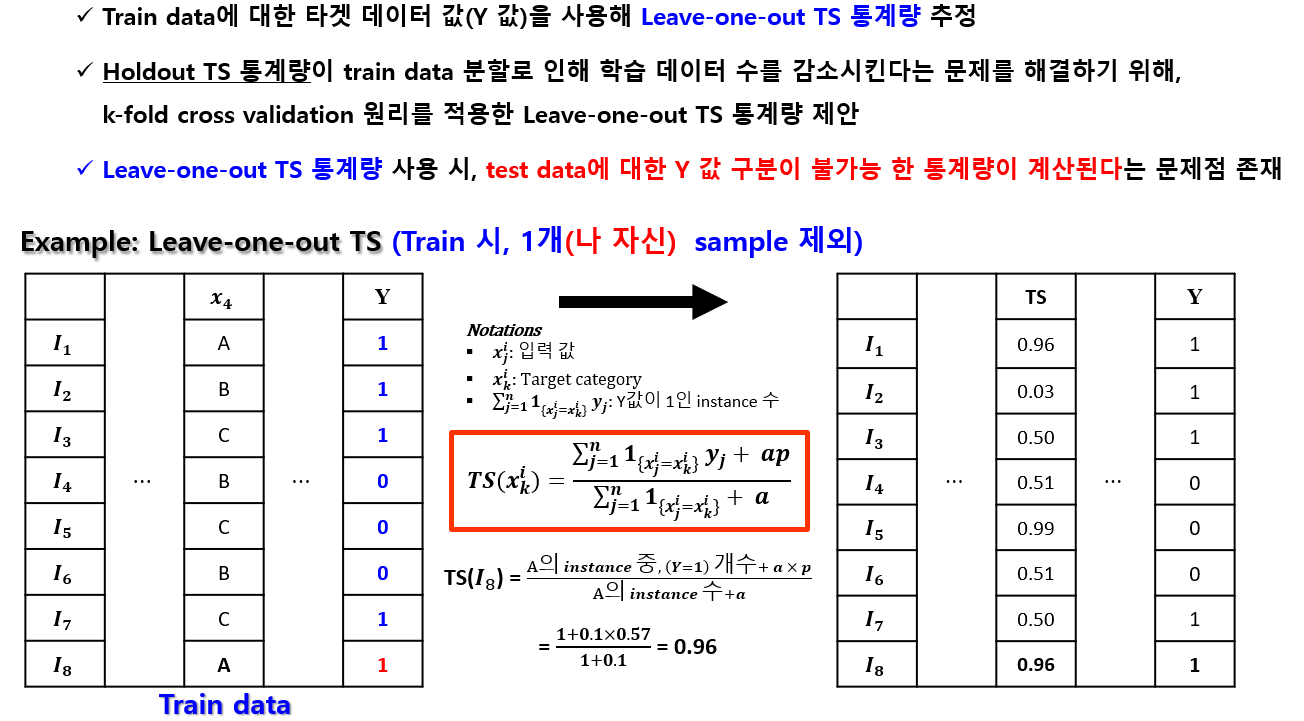

In [12]:
# train set과 test set 구분을 위한 package 불러오기
from sklearn.model_selection import train_test_split

# encoding에는 train set만 사용됨
train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

# train -> train_new 로 될 예정이므로, 미리 데이터프레임 생성
train_new = train.copy()
train_new[:] = np.nan
train_new['Sex_mean'] = np.nan

In [13]:
# k-fold 구분을 위해 package 불러오기
from sklearn.model_selection import StratifiedKFold

# K-fold 만들기 (k=5)
X_train = train.drop(target, axis=1)
Y_train = train[target]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold iteration
for tr_idx, val_idx in skf.split(X_train, Y_train):
    X_train, X_val = train.iloc[tr_idx], train.iloc[val_idx]

    # train set에서 구한 mean encoded 값을 validation set에 매핑
    means = X_val['Sex'].map(X_train.groupby('Sex')[target].mean())
    X_val['Sex_mean'] = means
    train_new.iloc[val_idx] = X_val

# 폴드에 속하지못한 데이터들은 글로벌 평균으로 채우기
global_mean = train[target].mean()
print('global mean: ', global_mean)

train_new['Sex'] = train_new['Sex'].fillna(global_mean)

global mean:  0.37640449438202245


In [14]:
train_new[['Sex', 'Sex_mean']].head()

,Sex,Sex_mean
331,male,0.184987
733,male,0.193029
382,male,0.177419
704,male,0.184000
813,female,0.751269


#### (4) Ordered TS

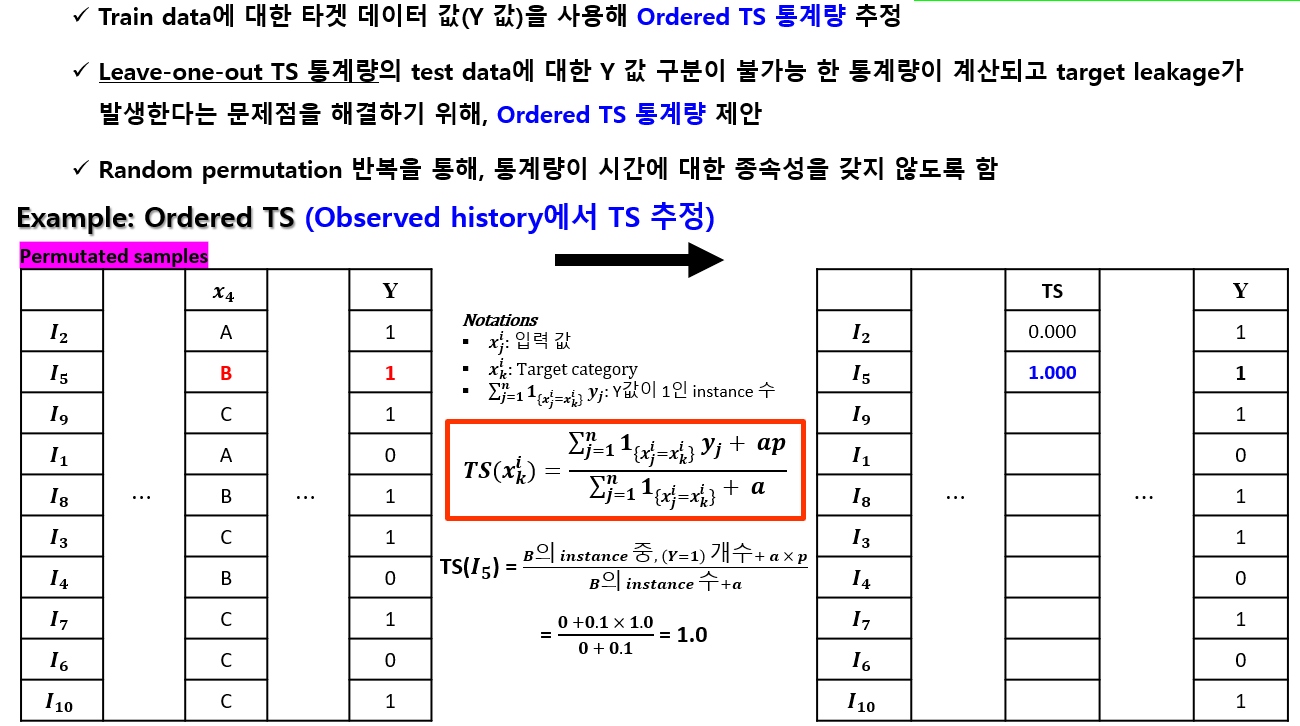

In [15]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 4.6 MB/s 


In [16]:
# import libraries
import category_encoders as ce
import pandas as pd
  
# Make dataset
train = pd.DataFrame({
    'color': ["red", "blue", "blue", "green", "red",
              "red", "black", "black", "blue", "green"],
    
    'interests': ["sketching", "painting", "instruments",
                  "sketching", "painting", "video games",
                  "painting", "instruments", "sketching",
                  "sketching"],
    
    'height': [68, 64, 87, 45, 54, 64, 67, 98, 90, 87],
    
    'grade': [1, 2, 3, 2, 3, 1, 4, 4, 2, 3], })
  
train

,color,interests,height,grade
0,red,sketching,68,1
1,blue,painting,64,2
2,blue,instruments,87,3
3,green,sketching,45,2
4,red,painting,54,3
5,red,video games,64,1
6,black,painting,67,4
7,black,instruments,98,4
8,blue,sketching,90,2
9,green,sketching,87,3


In [17]:
# Define train and target
target = train[['grade']]
train = train.drop('grade', axis = 1)

In [18]:
# Define catboost encoder
cbe_encoder = ce.cat_boost.CatBoostEncoder()
  
# Fit encoder and transform the features
cbe_encoder.fit(train, target)
train_cbe = cbe_encoder.transform(train)

In [19]:
train_cbe

,color,interests,height
0,1.875,2.100000,68
1,2.375,2.875000,64
2,2.375,3.166667,87
3,2.500,2.100000,45
4,1.875,2.875000,54
5,1.875,2.500000,64
6,3.500,2.875000,67
7,3.500,3.166667,98
8,2.375,2.100000,90
9,2.500,2.100000,87
